In [37]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import datetime as dt
import re
import csv
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
app_reviews_df = pd.read_csv('ulasan.csv')
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              18000 non-null  object
 1   userName              18000 non-null  object
 2   userImage             18000 non-null  object
 3   content               18000 non-null  object
 4   score                 18000 non-null  int64 
 5   thumbsUpCount         18000 non-null  int64 
 6   reviewCreatedVersion  15758 non-null  object
 7   at                    18000 non-null  object
 8   replyContent          12592 non-null  object
 9   repliedAt             12592 non-null  object
 10  appVersion            15758 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


In [39]:
clean_df = app_reviews_df.dropna()
clean_df = clean_df.drop_duplicates()

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {
    "abis": "habis",
    "aj": "aja",
    "ane": "saya",
    "bbrp": "beberapa",
    "blm": "belum",
    "bray": "teman",
    "bro": "kakak",
    "bs": "bisa",
    "cuan": "keuntungan",
    "dgn": "dengan",
    "dl": "dulu",
    "dlm": "dalam",
    "dr": "dari",
    "elo": "kamu",
    "gan": "kakak",
    "ga": "tidak",
    "gak": "tidak",
    "gk": "tidak",
    "gue": "saya",
    "gw": "saya",
    "jd": "jadi",
    "jg": "juga",
    "kalo": "kalau",
    "kl": "kalau",
    "krn": "karena",
    "kt": "kita",
    "loe": "kamu",
    "lu": "kamu",
    "masi": "masih",
    "mnt": "minta",
    "ngebug": "bermasalah",
    "ngelag": "lambat",
    "ny": "nya",
    "om": "bapak",
    "pantes": "pantasan",
    "pdhl": "padahal",
    "sist": "kakak",
    "sm": "sama",
    "sy": "saya",
    "td": "tadi",
    "tdk": "tidak",
    "tp": "tapi",
    "trs": "terus",
    "udh": "sudah",
    "udah": "sudah",
    "yg": "yang"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [40]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [41]:
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    8500
positive    1983
neutral      561
Name: count, dtype: int64


In [42]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11044 entries, 1 to 17998
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              11044 non-null  object
 1   userName              11044 non-null  object
 2   userImage             11044 non-null  object
 3   content               11044 non-null  object
 4   score                 11044 non-null  int64 
 5   thumbsUpCount         11044 non-null  int64 
 6   reviewCreatedVersion  11044 non-null  object
 7   at                    11044 non-null  object
 8   replyContent          11044 non-null  object
 9   repliedAt             11044 non-null  object
 10  appVersion            11044 non-null  object
 11  text_clean            11044 non-null  object
 12  text_casefoldingText  11044 non-null  object
 13  text_slangwords       11044 non-null  object
 14  text_tokenizingText   11044 non-null  object
 15  text_stopword         11044 non-null  obj

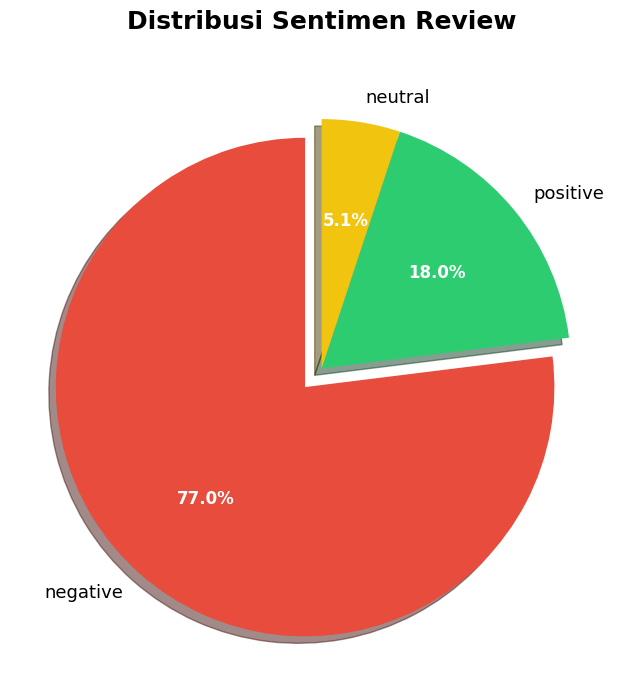

In [43]:
import matplotlib.pyplot as plt

# Warna konsisten dengan wordcloud
colors = {
    'positive': '#2ecc71',  # Hijau cerah
    'negative': '#e74c3c',  # Merah terang
    'neutral': '#f1c40f'    # Kuning emas
}

# Ambil data dan label
labels = clean_df['polarity'].value_counts().index.tolist()
sizes = clean_df['polarity'].value_counts().tolist()
chart_colors = [colors.get(label, 'gray') for label in labels]

# Buat explode otomatis (hanya tarik kategori pertama)
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]

# Pie chart yang lebih estetik
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    x=sizes,
    labels=labels,
    autopct='%1.1f%%',
    explode=explode,
    colors=chart_colors,
    startangle=90,
    shadow=True,
    textprops={'fontsize': 13}
)

# Styling teks persentase
plt.setp(autotexts, size=12, weight='bold', color='white')

# Judul
ax.set_title('Distribusi Sentimen Review', fontsize=18, fontweight='bold', pad=20)

# Tampilkan chart
plt.tight_layout()
plt.show()


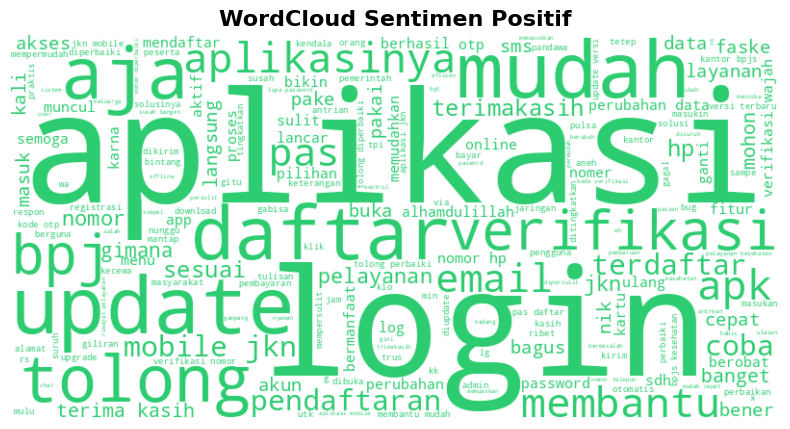

Jumlah kata positif: 26945


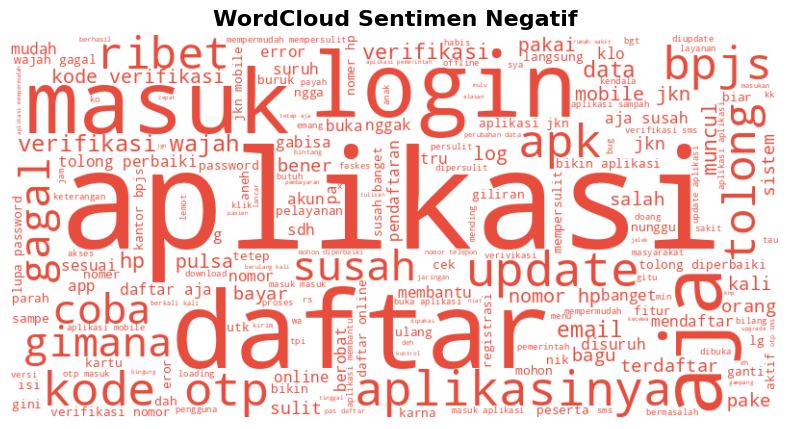

Jumlah kata negatif: 148733


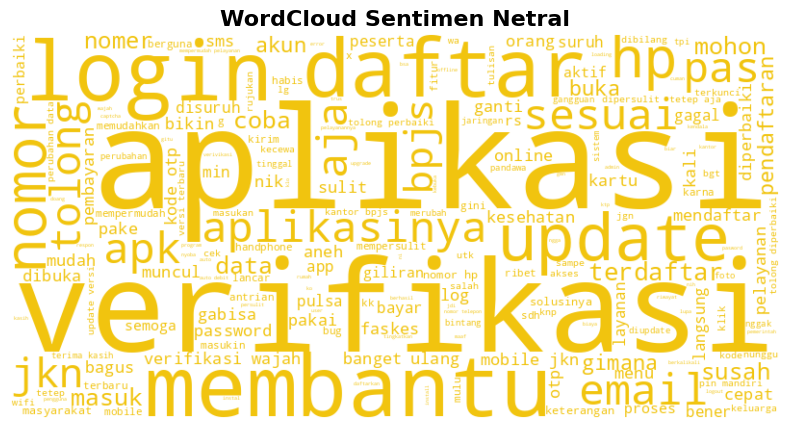

Jumlah kata netral: 6298


In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fungsi warna khusus per sentimen
def make_color_func(hex_color):
    def color_func(*args, **kwargs):
        return hex_color
    return color_func

# Filter data berdasarkan sentimen
positive_text = ' '.join(clean_df[clean_df['polarity'] == 'positive']['text_akhir'].astype(str).tolist())
negative_text = ' '.join(clean_df[clean_df['polarity'] == 'negative']['text_akhir'].astype(str).tolist())
neutral_text = ' '.join(clean_df[clean_df['polarity'] == 'neutral']['text_akhir'].astype(str).tolist())

# ====================== Positif ======================
wordcloud_positive = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive.recolor(color_func=make_color_func('#2ecc71')), interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Positif', fontsize=16, fontweight='bold')
plt.show()
print('Jumlah kata positif:', len(positive_text.split()))
print('='*100)

# ====================== Negatif ======================
wordcloud_negative = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative.recolor(color_func=make_color_func('#e74c3c')), interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Negatif', fontsize=16, fontweight='bold')
plt.show()
print('Jumlah kata negatif:', len(negative_text.split()))
print('='*100)

# ====================== Netral ======================
wordcloud_neutral = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(neutral_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral.recolor(color_func=make_color_func('#f1c40f')), interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Netral', fontsize=16, fontweight='bold')
plt.show()
print('Jumlah kata netral:', len(neutral_text.split()))
print('='*100)

In [45]:
X = clean_df['text_akhir']
y = clean_df['polarity']
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [46]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df.head()

,aja,akses,aktif,akun,ampun,anak,aneh,anggota,antrian,apk,...,update,upgrade,utk,verifikasi,verivikasi,versi,via,wa,wajah,wifi
0,0.398922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.187309,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.306085,0.0,0.0,0.0,0.0,0.428409,0.000000
2,0.158944,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.149260,0.0,0.0,0.0,0.0,0.208911,0.305601
3,0.256150,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.120272,0.0,0.0,0.0,0.0,0.336675,0.246250
4,0.000000,0.327068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [69]:
# SVM dengan TF-IDF (60/40)
tfidf_svm = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf_svm = tfidf_svm.fit_transform(X)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf_svm, y, test_size=0.4, random_state=70)
svm_model = SVC()
svm_model.fit(X_train_svm.toarray(), y_train_svm)
y_pred_train_svm = svm_model.predict(X_train_svm.toarray())
y_pred_test_svm = svm_model.predict(X_test_svm.toarray())
print('SVM - accuracy_train:', accuracy_score(y_train_svm, y_pred_train_svm))
print('SVM - accuracy_test:', accuracy_score(y_test_svm, y_pred_test_svm))

SVM - accuracy_train: 0.9077875037730154
SVM - accuracy_test: 0.8526482571299231


In [62]:
# Logistic Regression dengan TF-IDF (80/20)
tfidf_lr = TfidfVectorizer(max_features=300, min_df=20, max_df=0.5)
X_tfidf_lr = tfidf_lr.fit_transform(X)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_tfidf_lr, y, test_size=0.2, random_state=42)
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_lr, y_train_lr)
y_pred_train_lr = logistic_regression.predict(X_train_lr)
y_pred_test_lr = logistic_regression.predict(X_test_lr)
print('Logistic Regression - accuracy_train:', accuracy_score(y_train_lr, y_pred_train_lr))
print('Logistic Regression - accuracy_test:', accuracy_score(y_test_lr, y_pred_test_lr))

Logistic Regression - accuracy_train: 0.8807017543859649
Logistic Regression - accuracy_test: 0.8678134902670892


In [93]:
# Random Forest dengan TF-IDF (80/20)
tfidf = TfidfVectorizer(max_features=300, min_df=20, max_df=0.5)
X_tfidf = tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=50)
rf_model = RandomForestClassifier(random_state=30)
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)
print('Random Forest - accuracy_train:', accuracy_score(y_train, y_pred_train))
print('Random Forest - accuracy_test:', accuracy_score(y_test, y_pred_test))

Random Forest - accuracy_train: 0.9912846632710809
Random Forest - accuracy_test: 0.8483476686283387
